In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

# load the aggregated flight data
data = pd.read_csv("../data/aggregated_flight_data.csv")
data.head()


,Carrier Reported Date of Data: Year,Carrier Reported Date of Data: Month,Carrier Reported Origin Airport: Alpha Code,Origin Airport: Unique Numeric Code,Origin Airport: World Area Code,Origin Airport: City Name,Carrier Reported Destination Airport: Alpha Code,Destination Airport: Numeric Code,Destination Airport: World Area Code,Destination Airport: City Name,...,Available Capacity: Payload Pounds,Available Seats,Passengers Transported,Freight Transported,Mail Transported,Ramp – Ramp in minutes,Airborne – in minutes,Carrier’s World Area Code,Carrier’s World Area Code (Duplicate),Load_Factor_Calculated
0,2021,7,ABE,30135,23,"Allentown/Bethlehem/Easton, PA",EWR,31703,21,"Newark, NJ",...,40100,172,9,1,1185,46,22,10.0,NaN,0.052326
1,2021,7,ABE,30135,23,"Allentown/Bethlehem/Easton, PA",JFK,31703,22,"New York, NY",...,48400,102,16,0,0,50,31,10.0,NaN,0.156863
2,2020,11,ABE,30135,23,"Allentown/Bethlehem/Easton, PA",PHL,34100,23,"Philadelphia, PA",...,40100,172,39,119,0,33,21,10.0,NaN,0.226744
3,2021,5,ABI,30136,74,"Abilene, TX",DFW,30194,74,"Dallas/Fort Worth, TX",...,38400,150,148,0,215,54,40,10.0,NaN,0.986667
4,2021,4,ABI,30136,74,"Abilene, TX",DFW,30194,74,"Dallas/Fort Worth, TX",...,35600,128,88,0,0,74,37,10.0,NaN,0.687500


In [2]:
data['ds'] = pd.to_datetime(data['Carrier Reported Date of Data: Year'].astype(str) + '-' + 
                                   data['Carrier Reported Date of Data: Month'].astype(str) + '-01')

average_passenger_weight = 200

data['passenger_weight'] = data['Passengers Transported'] * average_passenger_weight
data['total_payload_transported'] = data['passenger_weight'] + data['Freight Transported'] + data['Mail Transported']

data['total_load_factor'] = data['total_payload_transported'] / data['Available Capacity: Payload Pounds']

data = data[['ds', 'Carrier Reported Origin Airport: Alpha Code', 'Carrier Reported Destination Airport: Alpha Code', 'total_load_factor']]

data = data.rename(columns={
    'Carrier Reported Origin Airport: Alpha Code': 'origin_airport',
    'Carrier Reported Destination Airport: Alpha Code': 'destination_airport',
    'total_load_factor': 'y'
})
data.head()

,ds,origin_airport,destination_airport,y
0,2021-07-01,ABE,EWR,0.074464
1,2021-07-01,ABE,JFK,0.066116
2,2020-11-01,ABE,PHL,0.197481
3,2021-05-01,ABI,DFW,0.776432
4,2021-04-01,ABI,DFW,0.494382


Due to large dataset, I'm resampling the dataset.

In [12]:
# df_resampled = data.set_index('ds').groupby(['origin_airport', 'destination_airport']).resample('MS').mean()
# df_resampled = df_resampled.dropna().reset_index()
# df_resampled.head()

,origin_airport,destination_airport,ds,y
0,ABE,EWR,2019-07-01,0.840974
1,ABE,EWR,2021-07-01,0.074464
2,ABE,JFK,2021-07-01,0.066116
3,ABE,JFK,2022-09-01,0.371901
4,ABE,JFK,2023-07-01,0.336170


In [ ]:
covid_disruption = pd.DataFrame({
    'holiday': 'covid_disruption',
    'ds': pd.to_datetime(['2020-03-01', '2023-04-30']),
    'lower_window': 0,
    'upper_window': 0,
})

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.2],
    'seasonality_prior_scale': [5.0, 10.0, 20.0]
}

# Create all combinations of the parameters
grid = ParameterGrid(param_grid)

# To store the best parameters and models for each group
best_results = {}

# Group the data by 'origin_airport' and 'destination_airport'
for (origin, destination), group_data in data.groupby(['origin_airport', 'destination_airport']):
    
    # Ensure the data is sorted by date
    group_data = group_data.sort_values(by='ds')
    
    # Aggregate the data by 'ds' (one row per date)
    group_data = group_data.groupby('ds').agg({'y': 'mean'}).reset_index()
    
    # Skip if there are less than 2 non-NaN rows
    if group_data['y'].notnull().sum() < 2:
        print(f"Skipping {origin} -> {destination}: Less than 2 non-NaN rows.")
        continue  # Skip this group if not enough data
    
    best_mae = float('inf')  # To track the best MAE for the group
    best_model = None
    best_params = None
    
    # Iterate over each combination of parameters
    for params in grid:
        try:
            # Initialize Prophet model with the current set of parameters
            model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                            seasonality_prior_scale=params['seasonality_prior_scale'],
                            holidays=covid_disruption)
            
            # Add custom seasonality and changepoints
            model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
            model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
            model.add_country_holidays(country_name='US')
            
            # Specify known changepoints like COVID-19
            changepoints = ['2020-03-01']
            model.changepoints = pd.to_datetime(changepoints)
            
            # Fit the model to the group data
            model.fit(group_data)
            
            # Perform cross-validation to evaluate the model
            df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days', parallel="processes")
            df_p = performance_metrics(df_cv)
            
            # Calculate the current MAE
            current_mae = df_p['mae'].mean()
            
            # If this is the best model so far, save it
            if current_mae < best_mae:
                best_mae = current_mae
                best_model = model
                best_params = params
        
        except Exception as e:
            print(f"Failed to fit for {origin} -> {destination} with params {params}: {e}")
            continue
    
    # Store the best model and parameters for this origin-destination pair
    if best_model:
        best_results[(origin, destination)] = {
            'model': best_model,
            'params': best_params,
            'mae': best_mae
        }
        print(f"Best params for {origin} -> {destination}: {best_params} with MAE: {best_mae}")
    else:
        print(f"No valid model for {origin} -> {destination}")


In [ ]:
all_forecasts = []

# Group the data by 'origin_airport' and 'destination_airport'
for (origin, destination), group_data in data.groupby(['origin_airport', 'destination_airport']):
    
    # Ensure the data is sorted by date
    group_data = group_data.sort_values(by='ds')
    
    # Aggregate the data by 'ds' (one row per date)
    group_data = group_data.groupby('ds').agg({'y': 'mean'}).reset_index()
    
    # Check if there are at least 2 non-null rows
    if group_data['y'].notnull().sum() < 2:
        print(f"Skipping {origin} -> {destination}: Less than 2 non-NaN rows.")
        continue  # Skip this group if not enough data
    
    # Fit the Prophet model to the current group's data
    model = Prophet()
    model.fit(group_data)
    
    # Create future dates for forecasting (next 12 months, monthly frequency)
    future_dates = model.make_future_dataframe(periods=12, freq='M')
    
    # Predict future values for this group
    forecast = model.predict(future_dates)
    
    # Add origin and destination to the forecast DataFrame
    forecast['origin_airport'] = origin
    forecast['destination_airport'] = destination
    
    # Select the relevant columns (ds, origin_airport, destination_airport, yhat, yhat_lower, yhat_upper)
    forecast = forecast[['ds', 'origin_airport', 'destination_airport', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Append the forecast to the list of all forecasts
    all_forecasts.append(forecast)

# Concatenate all the individual forecasts into one DataFrame
final_forecast_df = pd.concat(all_forecasts, ignore_index=True)

# Display the forecast for all airport pairs
print(final_forecast_df.head())

In [9]:
print(final_forecast_df)

               ds origin_airport destination_airport      yhat  yhat_lower  \
0      2019-07-01            ABE                 EWR  0.840968    0.840968   
1      2021-07-01            ABE                 EWR  0.074457    0.074457   
2      2021-07-31            ABE                 EWR  3.682336    3.682336   
3      2021-08-31            ABE                 EWR -3.512934   -3.512934   
4      2021-09-30            ABE                 EWR -1.283600   -1.283600   
...           ...            ...                 ...       ...         ...   
148330 2025-01-31            XNA                 ORD  0.445852    0.271520   
148331 2025-02-28            XNA                 ORD -0.598055   -0.758218   
148332 2025-03-31            XNA                 ORD -0.708880   -0.874462   
148333 2025-04-30            XNA                 ORD  0.901978    0.731797   
148334 2025-05-31            XNA                 ORD  0.817178    0.664620   

        yhat_upper  
0         0.840968  
1         0.074457  


In [4]:
# resample the data to monthly frequency, taking the mean of 'Load_Factor_Calculated'
monthly_data = data['Load_Factor_Calculated'].resample('ME').mean()
monthly_data = monthly_data.dropna()
monthly_data = monthly_data.reset_index()
monthly_data.columns = ['ds', 'y']
print(monthly_data.head())

          ds         y
0 2013-08-31  0.828379
1 2013-09-30  0.787506
2 2013-10-31  0.795360
3 2013-11-30  0.769716
4 2013-12-31  0.803287


In [5]:
covid_disruption = pd.DataFrame({
    'holiday': 'covid_disruption',
    'ds': pd.to_datetime(['2020-03-01', '2023-04-30']),
    'lower_window': 0,
    'upper_window': 0,
})
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2],
    'seasonality_prior_scale': [5.0, 10.0, 20.0]
}

# create combinations of all parameters
grid = ParameterGrid(param_grid)

# track best MAE
best_params = None
best_mae = float('inf')

for params in grid:
    # initialize Prophet model with parameters from the grid
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    holidays=covid_disruption)
    
    model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
    model.add_country_holidays(country_name='US')
    
    # specify changepoints manually for known disruptions like COVID-19
    changepoints = ['2020-03-01']
    model.changepoints = pd.to_datetime(changepoints)
    model.fit(monthly_data)
    
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    
    current_mae = df_p['mae'].mean()
    if current_mae < best_mae:
        best_mae = current_mae
        best_params = params

print(f"Best Parameters: {best_params}, Best MAE: {best_mae}")


16:52:43 - cmdstanpy - INFO - Chain [1] start processing
16:52:43 - cmdstanpy - INFO - Chain [1] done processing
16:52:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:52:43 - cmdstanpy - INFO - Chain [1] start processing
16:52:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/16 [00:00<?, ?it/s]16:52:43 - cmdstanpy - INFO - Chain [1] start processing
16:52:43 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  5.78it/s]16:52:43 - cmdstanpy - INFO - Chain [1] start processing
16:52:44 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  4.94it/s]16:52:44 - cmdstanpy - INFO - Chain [1] start processing
16:52:44 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:02,  5.17it/s]16:52:44 - cmdstanpy - INFO - Chain [1] start processing
16:52:44 - cmdstanpy - INFO - Chain [1] done p

Best Parameters: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0}, Best MAE: 0.24884056402340046


16:58:20 - cmdstanpy - INFO - Chain [1] start processing
16:58:20 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


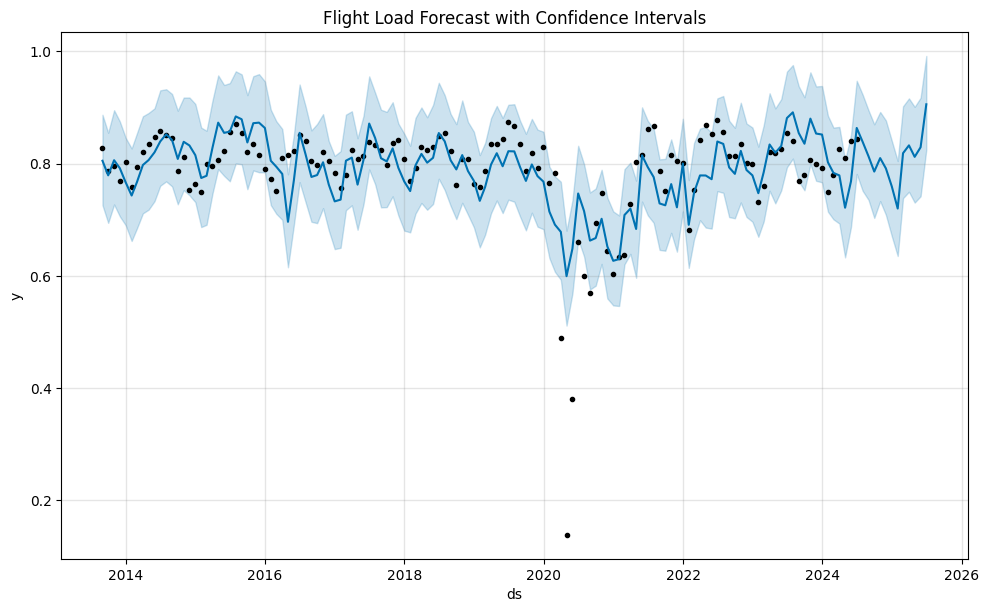

In [6]:
# refit the Prophet model with best parameters
best_model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=5.0, holidays=covid_disruption)
best_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
best_model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
best_model.add_country_holidays(country_name='US')
best_model.fit(monthly_data)

# create a future dataframe (e.g., for the next 12 months)
future = best_model.make_future_dataframe(periods=12, freq='ME')
forecast = best_model.predict(future)

best_model.plot(forecast)
plt.title('Flight Load Forecast with Confidence Intervals')
plt.show()

In [9]:
# perform cross-validation
# Initial period: 730 days (2 years), Period: 180 days, Horizon: 365 days (1 year forecast)
df_cv = cross_validation(best_model, initial='730 days', period='180 days', horizon='365 days')

# compute performance metrics like MAE, RMSE, and sMAPE for each time window
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mae', 'rmse', 'mape', 'mdape', 'coverage']])

  0%|          | 0/16 [00:00<?, ?it/s]17:14:25 - cmdstanpy - INFO - Chain [1] start processing
17:14:42 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:16<04:07, 16.48s/it]17:14:42 - cmdstanpy - INFO - Chain [1] start processing
17:15:00 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:34<04:05, 17.56s/it]17:15:00 - cmdstanpy - INFO - Chain [1] start processing
17:15:21 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:55<04:06, 18.98s/it]17:15:21 - cmdstanpy - INFO - Chain [1] start processing
17:15:21 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:55<02:19, 11.66s/it]17:15:21 - cmdstanpy - INFO - Chain [1] start processing
17:15:22 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:56<01:23,  7.61s/it]17:15:22 - cmdstanpy - INFO - Chain [1] start processing
17:15:22 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 6/16 [00:56<00:52,  5.20s/it]17:15:22

     horizon       mae      rmse      mape     mdape  coverage
0    36 days  0.188681  0.501523  0.251590  0.061970  0.368421
1    40 days  0.188402  0.501515  0.251172  0.061970  0.421053
2    42 days  0.189234  0.501543  0.252284  0.061970  0.368421
3    46 days  0.216396  0.516649  0.300655  0.071493  0.368421
4    47 days  0.219567  0.516848  0.305683  0.098208  0.368421
..       ...       ...       ...       ...       ...       ...
146 358 days  0.238092  0.407031  0.307290  0.168188  0.421053
147 359 days  0.215903  0.387684  0.279222  0.138430  0.447368
148 363 days  0.204308  0.371558  0.264939  0.168188  0.421053
149 364 days  0.199093  0.370300  0.258547  0.162552  0.473684
150 365 days  0.196708  0.369692  0.255372  0.162552  0.500000

[151 rows x 6 columns]


In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('../data/flight_load_forecast.csv', index=False)
print("Forecast saved to 'flight_load_forecast.csv'")


Forecast saved to 'flight_load_forecast.csv'
